In [16]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import compute_pdf_nbin, slopes_r_p, slopes_r_p_onlysub, slopes_r_p_mix, slope_time, slope_maps
import regression
#from coare_functions import *
import meteo
import lcl
import metpy.calc as mpcalc
from metpy.units import units


import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [4]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU_new.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU_new.npy')

In [5]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)


perc_step = 5
nbins = int(100/perc_step) # Number of bins.
popmean = 0

In [ ]:
# retrieve SST, temperature, "buoyancy" and PBLH

In [6]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))

In [7]:
# lat and lon
lon_M = ds_hourly['nav_lon'].values
lat_M = ds_hourly['nav_lat'].values

In [8]:
sst_day = ds_hourly['SST'].groupby('time_counter.day').mean()            
sst_day = sst_day.where(sea_mask, drop=False).values; 

In [9]:
T2 = ds_hourly['T2'].groupby('time_counter.day').mean()
T2 = T2.where(sea_mask, drop=False).values

In [59]:
s = 100

dT2 = np.zeros(T2.shape)
T2_smooth = np.zeros(T2.shape)

for t in range(0,T2.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    T2_smooth[t] = gm.nan_gaussian_filter(T2[t],s)                             
    dT2[t] = T2[t] - T2_smooth[t]
    

0
10
20


In [10]:
my_save_data('/venus/tesi_ale/data_EU/T/daily/FEB/dT2_day_feb.npy', [dT2])

In [8]:
buoya = sst_day - T2

In [10]:
PBLH_day = ds_hourly['PBLH'].groupby('time_counter.day').mean()            
PBLH_day = PBLH_day.where(sea_mask, drop=False).values; 

In [48]:
buoya_flat = buoya[~np.isnan(buoya)].flatten()
#buoya_flat = np.sort(buoya_flat)
perc_99 = np.percentile(buoya_flat, 99); print(f'perc 99 = {perc_99}')
perc_95 = np.percentile(buoya_flat, 95); print(f'perc 95 = {perc_95}')
perc_75 = np.percentile(buoya_flat, 75); print(f'perc 75 = {perc_75}')
perc_3_5 = np.percentile(buoya_flat, 3.5); print(f'perc 3.5 = {perc_3_5}')

perc 99 = 1.313720703125
perc 95 = 1.12005615234375
perc 75 = 0.870086669921875
perc 3.5 = -0.00152587890625


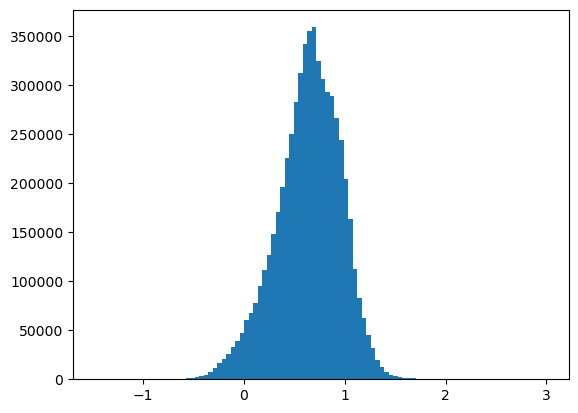

In [46]:
res= plt.hist(buoya_flat[buoya_flat<3], bins=100)
freq = res[0]/(len(buoya_flat[buoya_flat<3]))
bin_ave = 0.5*(res[1][0:-1]+res[1][1:])

In [5]:
### LOAD ANOMALIES DATA FROM SAVED FILES

with open('/venus/tesi_ale/data_EU/SST/daily/FEB/dSST_day_feb.npy', 'rb') as f:
    dsst_day = np.load(f)
    
with open('/venus/tesi_ale/data_EU/PBLH/daily/FEB/dPBLH_day_feb.npy', 'rb') as f:
    dPBLH_day = np.load(f)

"with open('/venus/tesi_ale/data_EU/PBLH/daily/FEB/dPBLH_day_feb.npy', 'rb') as f:\n    dPBLH_day = np.load(f)"

In [ ]:
#######   SEE BEHAVIOUR OF SURFACE HEAT FLUXES

In [73]:
LH = ds_hourly['LH'].groupby('time_counter.day').mean()            
LH = LH.where(sea_mask, drop=False).values; 

#HFX = ds_hourly['HFX'].groupby('time_counter.day').mean()            
#HFX = HFX.where(sea_mask, drop=False).values; 

In [23]:
s = 100

dLH = np.zeros(LH.shape)
dHFX = np.zeros(HFX.shape)

for t in range(0,LH.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    LH_ave = gm.nan_gaussian_filter(LH[t],s)                             
    dLH[t] = LH[t] - LH_ave
    
    HFX_ave = gm.nan_gaussian_filter(HFX[t],s)                             
    dHFX[t] = HFX[t] - HFX_ave

0
10
20


In [24]:
my_save_data('/venus/tesi_ale/data_EU/LH/daily/FEB/dLH_day_feb.npy', [dLH])
my_save_data('/venus/tesi_ale/data_EU/HFX/daily/FEB/dHFX_day_feb.npy', [dHFX])

file already exists - DELETING IT and creating it anew
file already exists - DELETING IT and creating it anew


In [ ]:
# DISTRIBUTIONS

In [10]:
with open('/venus/tesi_ale/data_EU/SST/daily/FEB/dSST_day_feb.npy', 'rb') as f:
    dsst_day = np.load(f)

In [7]:
with open('/venus/tesi_ale/data_EU/LH/daily/FEB/dLH_day_feb.npy', 'rb') as f:
    dLH = np.load(f)

"with open('/venus/tesi_ale/data_EU/LH/daily/FEB/dLH_day_feb.npy', 'rb') as f:\n    dLH = np.load(f)\n    \nwith open('/venus/tesi_ale/data_EU/HFX/daily/FEB/dHFX_day_feb.npy', 'rb') as f:\n    dHFX = np.load(f)"

In [ ]:
with open('/venus/tesi_ale/data_EU/HFX/daily/FEB/dHFX_day_feb.npy', 'rb') as f:
    dHFX = np.load(f)

In [ ]:
#########    LH     #########

In [14]:
# dSST vs dLH
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

pdist_x, pdist_dLH, pstd_dLH, pstderr_dLH, pnpoints_dLH, ppvalue_dLH =   distrib_2d(dsst_day, dLH, perc_step, nbins, popmean, perc_fixbin='perc')

In [15]:
# SST vs LH
pdist_sst, pdist_LH, pstd_LH, pstderr_LH, pnpoints_LH, ppvalue_LH =   distrib_2d(sst_day, LH, perc_step, nbins, popmean, perc_fixbin='perc')

In [60]:
# save distributions data - DONE
'''p_dsst = [pdist_sst, pdist_LH, pstd_LH, pstderr_LH, pnpoints_LH, ppvalue_LH]
my_save_data('/venus/tesi_ale/data_EU/LH/daily/FEB/pdist_sst_LH_day_feb.npy', p_dsst)'''

file already exists - DELETING IT and creating it anew


/venus/tesi_ale/img_EU/LH/daily/FEB/scatterFIT_dsst_dLH_feb.png


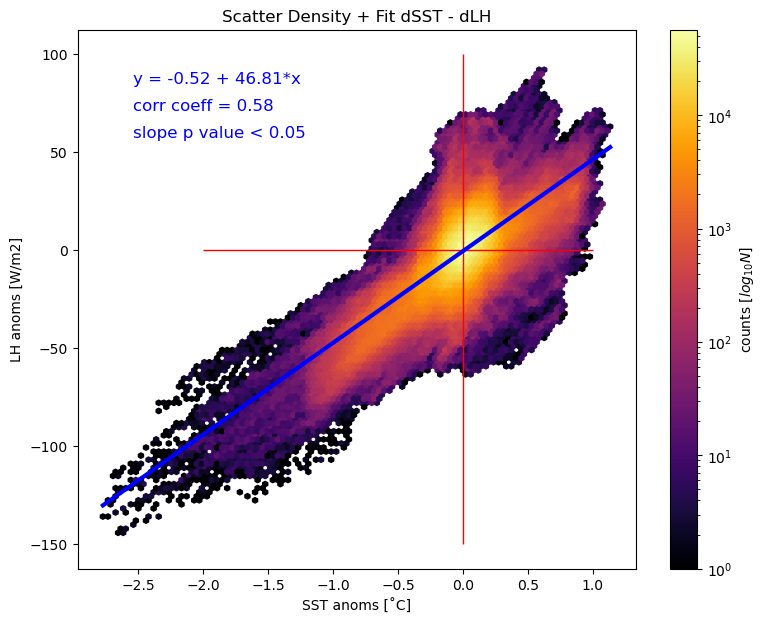

In [11]:
##### FITTING #####

# # corr length
# L = 80
# nskip = int(L/2)
# nt = int(2)
# nbin = 50
dsst = True

if not dsst:
    x =  (sst_day-273.15).copy()     # (sst_day[~np.isnan(sst_day)]-273.15).copy()       #[::nt,::nskip,::nskip].copy()
    y =  LH.copy()     #LH[~np.isnan(LH)].copy()
    fit, corcoe, p_value, t_value_cannelli, p_value_cannelli = slopes_r_p_mix(x, y, nt, nskip)
    title=' Scatter Density + Fit SST - LH'
    xlabel='SST [˚C]'
    ylabel='LH [W/m2]'
    
else:
    x = dsst_day.copy()    #dsst_day[~np.isnan(dsst_day)].copy()       #[::nt,::nskip,::nskip].copy()
    y = dLH.copy()         #dLH[~np.isnan(dLH)].copy()
    fit, corcoe, p_value, t_value_cannelli, p_value_cannelli = slopes_r_p_mix(x, y, nt, nskip)
    title='Scatter Density + Fit dSST - dLH'
    xlabel='SST anoms [˚C]'
    ylabel='LH anoms [W/m2]'
    miny = -150 ; maxy = 100
    minx = -2 ; maxx = 1
    

fig = density_hexbin(x,y,fit=fit,corcoe=corcoe,grdsz=100,title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno')

if dsst:
    plt.vlines(0, ymin=miny, ymax=maxy, color='red', linewidth=1)
    plt.hlines(0, xmin=minx, xmax=maxx, color='red', linewidth=1)
    
if p_value_cannelli < 0.05:
    plt.annotate('slope p value < 0.05', xy=(0.1, 0.8), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(0.1, 0.8), \
                         xycoords='axes fraction', fontsize=12, color='b')

    

path_img = '/venus/tesi_ale/img_EU/LH/daily/FEB/' 
filename = path_img + 'scatterFIT_dsst_dLH_feb.png' if dsst else path_img + 'scatterFIT_sst_LH_feb.png'
#plt.savefig(filename)
print(filename)
del filename

In [ ]:
#########    HFX     #########

In [12]:
# dSST vs dHFX
pdist_x, pdist_dHFX, pstd_dHFX, pstderr_dHFX, pnpoints_dHFX, ppvalue_dHFX =   distrib_2d(dsst_day, dHFX, perc_step, nbins, popmean, perc_fixbin='perc')


In [13]:
# SST vs HFX
pdist_sst, pdist_HFX, pstd_HFX, pstderr_HFX, pnpoints_HFX, ppvalue_HFX =   distrib_2d(sst_day, HFX, perc_step, nbins, popmean, perc_fixbin='perc')


NameError: name 'sst_day' is not defined

In [64]:
p_sst = [pdist_x, pdist_dHFX, pstd_dHFX, pstderr_dHFX, pnpoints_dHFX, ppvalue_dHFX]
my_save_data('/venus/tesi_ale/data_EU/HFX/daily/FEB/pdist_dsst_dHFX_day_feb.npy', p_sst)

file already exists - DELETING IT and creating it anew


/venus/tesi_ale/img_EU/HFX/daily/FEB/scatterFIT_sst_HFX_feb.png


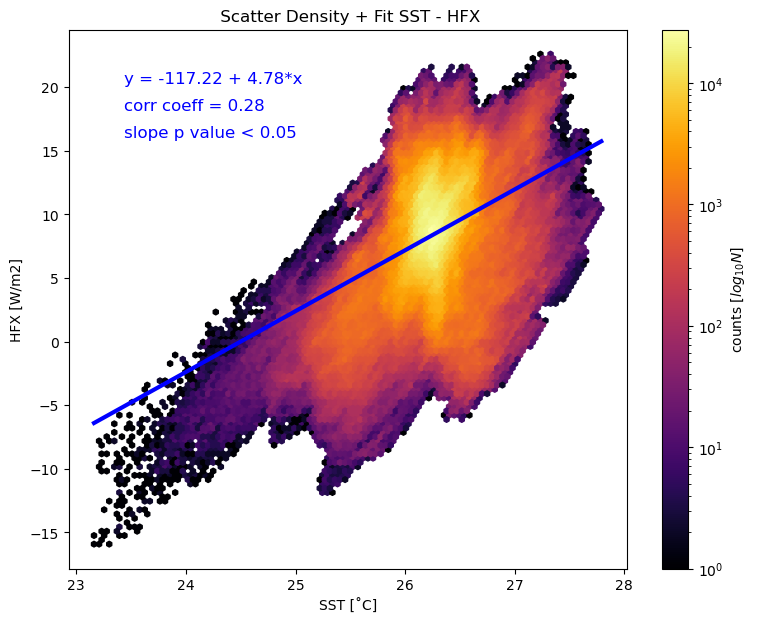

In [26]:
##### FITTING #####

# # corr length
# L = 80
# nskip = int(L/2)
# nt = int(2)
# nbin = 50
dsst = False

if not dsst:
    x = (sst_day-273.15).copy()       #[::nt,::nskip,::nskip].copy()
    y = HFX.copy()
    fit_hfx, corcoe_hfx, p_value_hfx, t_value_cannelli_hfx, p_value_cannelli_hfx = slopes_r_p_mix(x, y, nt, nskip)
    title=' Scatter Density + Fit SST - HFX'
    xlabel='SST [˚C]'
    ylabel='HFX [W/m2]'
else:
    x = dsst_day.copy()       #[::nt,::nskip,::nskip].copy()
    y = dHFX.copy()
    fit_hfx, corcoe_hfx, p_value_hfx, t_value_cannelli_hfx, p_value_cannelli_hfx = slopes_r_p_mix(x, y, nt, nskip)
    title='Scatter Density + Fit dSST - dHFX'
    xlabel='SST anoms [˚C]'
    ylabel='HFX anoms [W/m2]'
    miny = -20 ; maxy = -miny
    minx = -2 ; maxx = 1


fig = density_hexbin(x,y,fit=fit_hfx,corcoe=corcoe_hfx,grdsz=100,title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno')
    
    
'''fig1 = scatterplot_fit(x, y, fit, title, xlabel, ylabel, fig)
plt.annotate('corr coeff = '+str(round(corcoe,2)), xy=(0.1, 0.85), \
                     xycoords='axes fraction', fontsize=12, color='orange')'''
if dsst:
    plt.vlines(0, ymin=miny, ymax=maxy, color='red', linewidth=1)
    plt.hlines(0, xmin=minx, xmax=maxx, color='red', linewidth=1)
    
    
if p_value_cannelli_hfx < 0.05:
    plt.annotate('slope p value < 0.05', xy=(0.1, 0.8), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(0.1, 0.8), \
                         xycoords='axes fraction', fontsize=12, color='b')


path_img = '/venus/tesi_ale/img_EU/HFX/daily/FEB/' 
filename = path_img + 'scatterFIT_dsst_dHFX_feb.png' if dsst else path_img + 'scatterFIT_sst_HFX_feb.png'
# plt.savefig(filename)
print(filename)
del filename

In [ ]:
#########    PBLH     #########

In [42]:
# dSST vs dPBLH
pdist_x, pdist_dPBLH, pstd_dPBLH, pstderr_dPBLH, pnpoints_dPBLH, ppvalue_dPBLH =   distrib_2d(dsst_day, dPBLH_day, perc_step, nbins, popmean, perc_fixbin='perc')
dist_x, dist_dPBLH, std_dPBLH, stderr_dPBLH, npoints_dPBLH, pvalue_dPBLH       =   distrib_2d(dsst_day, dPBLH_day, perc_step, nbins, popmean, perc_fixbin='fb')


In [45]:
# dSST vs PBLH
pdist_x, pdist_PBLH, pstd_PBLH, pstderr_PBLH, pnpoints_PBLH, ppvalue_PBLH =   distrib_2d(x, PBLH_day, perc_step, nbins, popmean, perc_fixbin='perc')
dist_x, dist_PBLH, std_PBLH, stderr_PBLH, npoints_PBLH, pvalue_PBLH       =   distrib_2d(x, PBLH_day, perc_step, nbins, popmean, perc_fixbin='fb')

In [ ]:
#### PLOTTING

one side probability for X2 > Xo2$ = 0.999999773912631 

/venus/tesi_ale/img_EU/LH/daily/FEB/scatterFIT_sst_LH_distribs.png


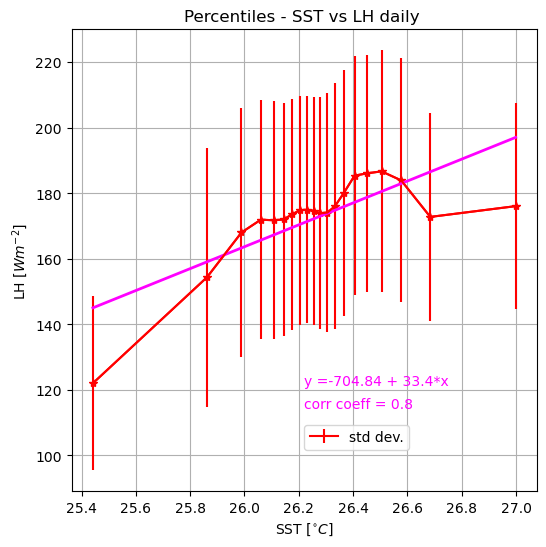

In [31]:
# dist_x vs dLH

full = True
from scipy.stats import chi2


fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

title = 'SST vs LH daily' if full else 'dSST vs dLH daily'
xlabel = 'SST [$^{\circ}C$]' if full else 'dSST [$^{\circ}C$]'
ylabel = 'LH [$Wm^{-2}$]' if full else 'dLH [$Wm^{-2}$]'

x_p = pdist_sst-273.15 if full else pdist_x 
var_p = pdist_LH if full else pdist_dLH
std_p = pstd_LH if full else pstd_dLH

fit_p, corcoe_p, p_value_p, p_chisq, p_prob_chisq_grt, p_chisq_rid = slopes_r_p(x_p,var_p, std_p)

p1 = ax1.plot(x_p, var_p, '*-r') 
ax1.plot(x_p, fit_p.slope*x_p + fit_p.intercept, color='magenta', linewidth=2)
ax1.errorbar(x_p, var_p, yerr=std_p, xerr=None, color='r', label='std dev.')
ax1.set_xlabel(xlabel)
ax1.set_ylabel(ylabel)
ax1.set_title(f'Percentiles - {title} '); # ax1.grid()

ax1.annotate('y =' + str(round(fit_p.intercept, 2)) + ' + ' + str(round(fit_p.slope, 2)) + '*x', xy=(0.5, 0.23), \
                     xycoords='axes fraction', fontsize=10, color='magenta')
ax1.annotate('corr coeff = '+str(round(corcoe_p,2)), xy=(0.5, 0.18), \
                     xycoords='axes fraction', fontsize=10, color='magenta')
ax1.legend(loc='lower right', bbox_to_anchor=(0.74, 0.075))

ax1.grid()

# cumulative probability of chi2
print(f'one side probability for X2 > Xo2 = {p_prob_chisq_grt} \n')

path_img = '/venus/tesi_ale/img_EU/LH/daily/FEB/' 
filename = path_img + 'scatterFIT_sst_LH_distribs.png' if full else path_img + 'scatterFIT_dsst_dLH_distribs.png'
plt.savefig(filename)
print(filename)
del filename

In [44]:
np.sum(  (var_p-fit_p.slope*x_p-fit_p.intercept)**2 / pstd_dLH**2 )

0.8083325469398234

one side probability for X2 > Xo2 = 0.999999796482727 

/venus/tesi_ale/img_EU/HFX/daily/FEB/scatterFIT_sst_HFX_distribs.png


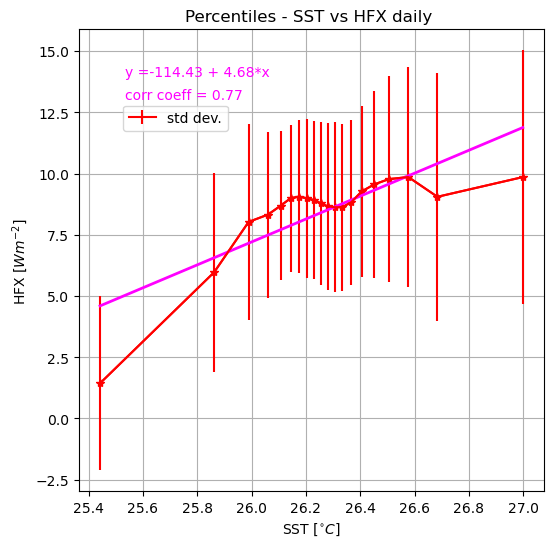

In [34]:
# dist_x vs dHFX

full = True



fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

title = 'SST vs HFX daily' if full else 'dSST vs dHFX daily'
xlabel = 'SST [$^{\circ}C$]' if full else 'dSST [$^{\circ}C$]'
ylabel = 'HFX [$Wm^{-2}$]' if full else 'dHFX [$Wm^{-2}$]'

x_p = pdist_sst-273.15 if full else pdist_x 
var_p = pdist_HFX if full else pdist_dHFX
std_p = pstd_HFX if full else pstd_dHFX

fit_p_hfx, corcoe_p_hfx, p_value_p_hfx, p_chisq_hfx, p_prob_chisq_grt_hfx, p_chisq_rid_hfx = slopes_r_p(x_p,var_p, std_p)

p1 = ax1.plot(x_p, var_p, '*-r') 
ax1.plot(x_p, fit_p_hfx.slope*x_p + fit_p_hfx.intercept, color='magenta', linewidth=2)
ax1.errorbar(x_p, var_p, yerr=std_p, xerr=None, color='r', label='std dev.')
ax1.set_xlabel(xlabel)
ax1.set_ylabel(ylabel)
ax1.set_title(f'Percentiles - {title} '); # ax1.grid()

ax1.annotate('y =' + str(round(fit_p_hfx.intercept, 2)) + ' + ' + str(round(fit_p_hfx.slope, 2)) + '*x', xy=(0.1, 0.9), \
                     xycoords='axes fraction', fontsize=10, color='magenta')
ax1.annotate('corr coeff = '+str(round(corcoe_p_hfx,2)), xy=(0.1, 0.85), \
                     xycoords='axes fraction', fontsize=10, color='magenta')
ax1.legend(loc='upper left', bbox_to_anchor=(0.08, 0.85))


ax1.grid()

# cumulative probability of chi2
print(f'one side probability for X2 > Xo2 = {p_prob_chisq_grt_hfx} \n')




path_img = '/venus/tesi_ale/img_EU/HFX/daily/FEB/' 
filename = path_img + 'scatterFIT_sst_HFX_distribs.png' if full else path_img + 'scatterFIT_dsst_dHFX_distribs.png'
# plt.savefig(filename)
print(filename)
del filename

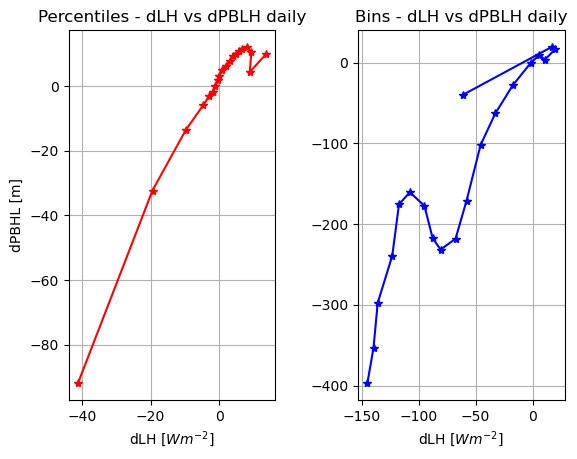

In [43]:
# dLH vs dPBLH

fig, (ax1, ax2) = plt.subplots(1, 2)

p1 = ax1.plot(pdist_dLH, pdist_dPBLH, '*-r')
ax1.set_xlabel('dLH [$Wm^{-2}$]')
ax1.set_ylabel('dPBHL [m]')
ax1.set_title('Percentiles - dLH vs dPBLH daily'); ax1.grid()

p2 = ax2.plot(dist_dLH, dist_dPBLH, '*-b')
ax2.set_xlabel('dLH [$Wm^{-2}$]')
ax2.set_title('Bins - dLH vs dPBLH daily'); ax2.grid()


plt.subplots_adjust(wspace=0.4, 
                    hspace=0.3)

In [13]:
#############    THERMODYNAMIC CONTRIBUTION TO dLH/dSST?

q2_day = ds_hourly['Q2'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))
q2_day = q2_day.groupby('time_counter.day').mean()
q2_day = q2_day.where(sea_mask, drop=False).values;

In [68]:
# retrieving pressure field

pres_base = xr.open_dataset(wrf_files[files_ls.index('PB.nc')])
pres_base = pres_base['PB']
# pres_base = pres_base[0,:,:]

pres = xr.open_dataset(wrf_files[files_ls.index('P.nc')]);  pres = pres['P']
pres = pres.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))
pres = (pres+pres_base)/100.
#pres = pres.groupby('time_counter.day').mean()


pres = pres.where(sea_mask, drop=False)


del pres_base

In [69]:
# retrieving pressure at surface level
pres_sfc = pres[:,0,:,:]
pres_sfc = pres_sfc.where(sea_mask, drop=False)
pres_sfc = pres_sfc.groupby('time_counter.day').mean()

del pres

In [ ]:
## load saturation vapour pressure
## computed in RH_calculation_only.ipynb

In [9]:
qsat_sst = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/qsat_sst_day.npy')
dqsat_sst = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/dqsat_sst_day.npy')

In [11]:
delta_q = qsat_sst*units('g/kg') - q2_day*units('kg/kg') ;   delta_q = delta_q.to('g/kg')

In [29]:
my_save_data('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/deltaQ_day_feb.npy', [delta_q.magnitude])

file already exists - DELETING IT and creating it anew


In [10]:
delta_q = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/deltaQ_day_feb.npy')

In [11]:
qsat_2m = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/qsat_2m_day.npy')
dqsat_2m = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/dqsat_2m_day.npy')

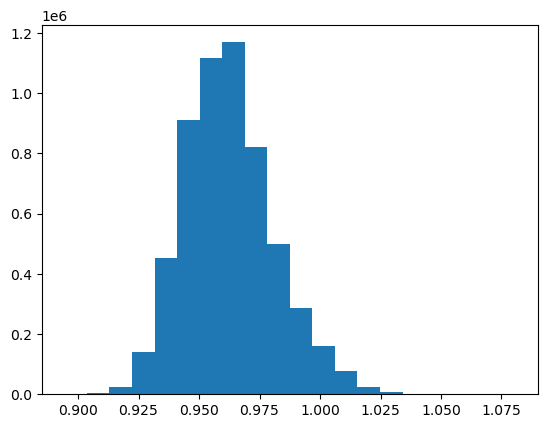

In [12]:
plt.hist(qsat_2m[~np.isnan(qsat_2m)]/qsat_sst[~np.isnan(qsat_sst)], bins=20)
plt.title(r'$qsat_{2m}/qsat_{sst}$')
plt.show()

(array([2.200000e+01, 1.170000e+02, 5.940000e+02, 6.169000e+03,
        3.001200e+04, 9.983300e+04, 3.281890e+05, 6.580750e+05,
        9.085720e+05, 1.227301e+06, 1.026047e+06, 5.742200e+05,
        3.270840e+05, 1.818860e+05, 1.124280e+05, 8.897500e+04,
        6.399200e+04, 3.713700e+04, 2.020500e+04, 3.031000e+03]),
 array([18.45053211, 18.65018439, 18.84983666, 19.04948894, 19.24914122,
        19.44879349, 19.64844577, 19.84809805, 20.04775032, 20.2474026 ,
        20.44705488, 20.64670715, 20.84635943, 21.04601171, 21.24566399,
        21.44531626, 21.64496854, 21.84462082, 22.04427309, 22.24392537,
        22.44357765]),
 <BarContainer object of 20 artists>)

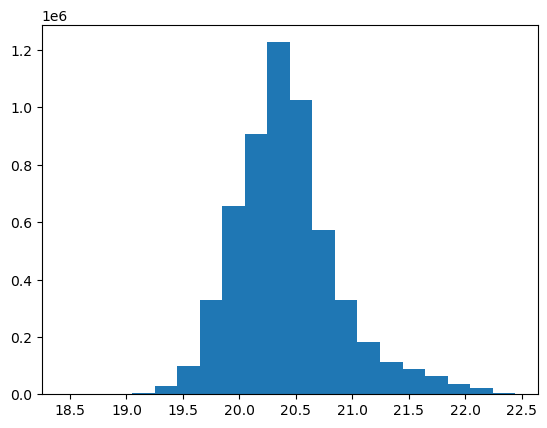

In [59]:
plt.hist(qsat_2m[~np.isnan(qsat_2m)], bins=20)
plt.title(r'$qsat_{2m}$')
plt.show()

(array([5.500000e+01, 9.100000e+01, 2.950000e+02, 7.470000e+02,
        1.305000e+03, 2.269000e+03, 6.982000e+03, 1.703600e+04,
        5.893000e+04, 1.371980e+05, 1.839190e+05, 8.098600e+05,
        2.145314e+06, 1.481786e+06, 5.128280e+05, 1.816730e+05,
        1.019170e+05, 4.401500e+04, 6.570000e+03, 1.099000e+03]),
 array([17.58691025, 17.87075338, 18.15459652, 18.43843966, 18.72228279,
        19.00612593, 19.28996906, 19.5738122 , 19.85765533, 20.14149847,
        20.42534161, 20.70918474, 20.99302788, 21.27687101, 21.56071415,
        21.84455729, 22.12840042, 22.41224356, 22.69608669, 22.97992983,
        23.26377296]),
 <BarContainer object of 20 artists>)

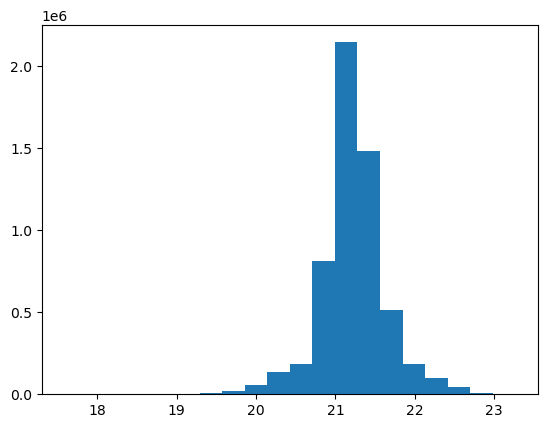

In [57]:
plt.hist(qsat_sst[~np.isnan(qsat_sst)], bins=20)
plt.title(r'$qsat_{sst}$')
plt.show()

(array([  5008.,  14888.,  45360.,  70714., 171323., 285781., 526573.,
        618616., 692106., 852720., 694816., 594288., 436565., 256720.,
        246770., 121319.,  39603.,  15165.,   2718.,   2836.]),
 array([0.01377331, 0.01405569, 0.01433806, 0.01462043, 0.0149028 ,
        0.01518517, 0.01546754, 0.01574991, 0.01603228, 0.01631465,
        0.01659702, 0.01687939, 0.01716176, 0.01744413, 0.01772651,
        0.01800888, 0.01829125, 0.01857362, 0.01885599, 0.01913836,
        0.01942073], dtype=float32),
 <BarContainer object of 20 artists>)

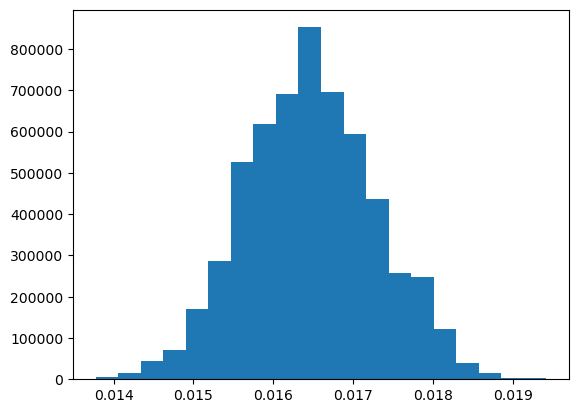

In [63]:
plt.hist(q2_day[~np.isnan(q2_day)], bins=20)
plt.title(r'$q2_{day}$')
plt.show()

In [13]:
d_delta_q = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/DdeltaQ_day_feb.npy')

In [14]:
dq2 = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/dq2_day_feb.npy')

0
10
20


/venus/tesi_ale/img_EU/T/daily/FEB/scatterFIT_T2-sst_dT2-dsst_feb.png


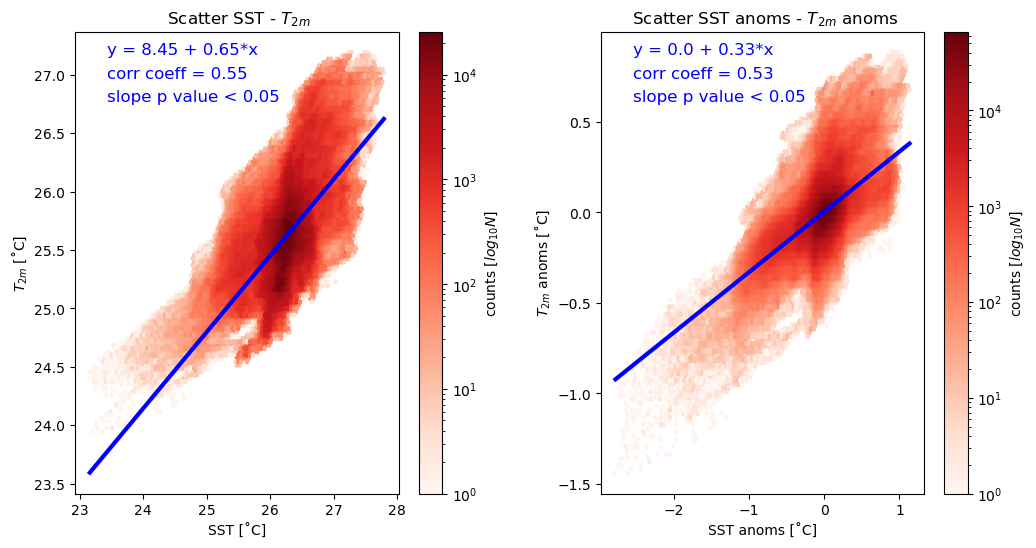

In [31]:
#####  LINKING T2 WITH SST


# variaiton of qsat and q2 with SST and dSST
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

anoms = False

x =  sst_day-273.15
y =  T2-273.15
fit_T2_sst, corcoe_T2_sst, p_value_T2_sst, p_value_cannelli_T2_sst, sigmas_coeffs_T2_sst = slopes_r_p_mix(x, y, nt, nskip)
   
density_hexbin_subplots(x, y, fit=fit_T2_sst, corcoe=corcoe_T2_sst, grdsz=100, fig=fig, ax=ax1,\
                        title=' Scatter SST - $T_{2m}$', xlabel='SST [˚C]', ylabel='$T_{2m}$ [˚C]', colormap='Reds')
    

    
if p_value_cannelli_T2_sst < 0.05:
    ax1.annotate('slope p value < 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    ax1.annotate('slope p value > 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=12, color='b')
    
    

    
    
    
xx = dsst_day
yy = dT2 
fit_dT2_dsst, corcoe_dT2_dsst, p_value_dT2_dsst, p_value_cannelli_dT2_dsst, sigmas_coeffs_dT2_dsst = slopes_r_p_mix(xx, yy, nt, nskip)
# ls_therm_contr = fit_qsat_sst.slope

density_hexbin_subplots(xx, yy, fit=fit_dT2_dsst, corcoe=corcoe_dT2_dsst, grdsz=100, fig=fig, ax=ax2,\
                        title=' Scatter SST anoms - $T_{2m}$ anoms', xlabel='SST anoms [˚C]', ylabel='$T_{2m}$ anoms [˚C]', colormap='Reds')




if p_value_cannelli_dT2_dsst < 0.05:
    ax2.annotate('slope p value < 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    ax2.annotate('slope p value > 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=12, color='b')



plt.subplots_adjust(wspace=0.3, 
                    hspace=0.4)

path_img = '/venus/tesi_ale/img_EU/T/daily/FEB/' 
filename = path_img + 'scatterFIT_T2-sst_dT2-dsst_feb.png' # if dsst else path_img + 'scatterFIT_sst_DELTAQ_feb.png'
# plt.savefig(filename)
print(filename)
del filename

/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/scatterFIT_dsst_dQsat_dQ2_feb.png


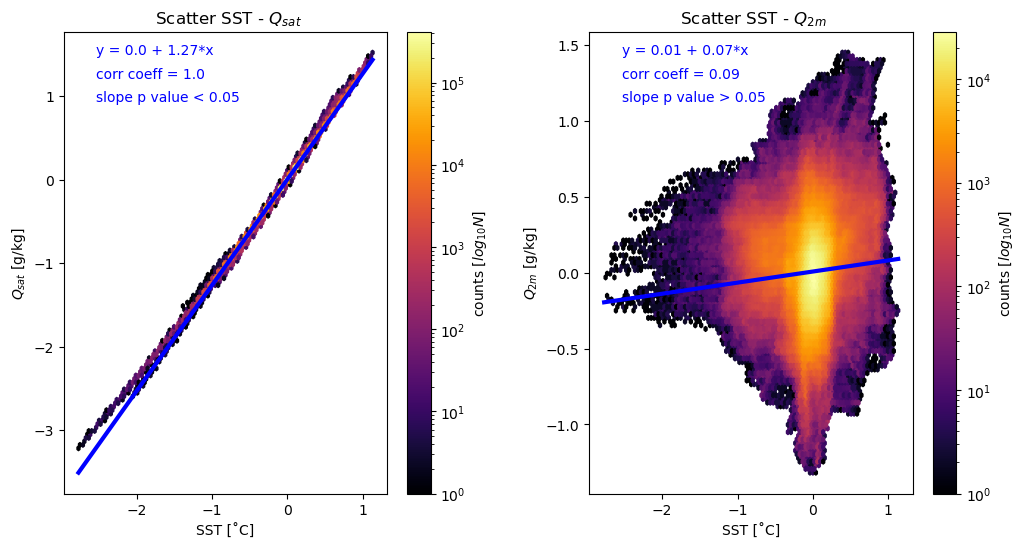

In [53]:
# variaiton of qsat and q2 with SST and dSST
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

anoms = True

x = dsst_day if anoms else (sst_day-273.15)
y = dqsat_sst if anoms else qsat_sst
fit_qsat_sst, corcoe_qsat, p_value_qsat, p_value_cannelli_qsat, sigmas_coeffs_qsat = slopes_r_p_mix(x, y, nt, nskip)
# ls_therm_contr = fit_qsat_sst.slope
   
density_hexbin_subplots(x, y, fit=fit_qsat_sst, corcoe=corcoe_qsat, grdsz=100, fig=fig, ax=ax1,\
                        title=' Scatter SST - $Q_{sat}$', xlabel='SST [˚C]', ylabel='$Q_{sat}$ [g/kg]', colormap='inferno')
    

if p_value_cannelli_qsat < 0.05:
    ax1.annotate('slope p value < 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    ax1.annotate('slope p value > 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=10, color='b')
    
    
xx = x
yy = dq2*1000. if anoms else q2_day*1000.
fit_q2_sst, corcoe_q2, p_value_q2, p_value_cannelli_q2, sigmas_coeffs_q2 = slopes_r_p_mix(xx, yy, nt, nskip)
# ls_therm_contr = fit_qsat_sst.slope

density_hexbin_subplots(xx, yy, fit=fit_q2_sst, corcoe=corcoe_q2, grdsz=100, fig=fig, ax=ax2,\
                        title=' Scatter SST - $Q_{2m}$', xlabel='SST [˚C]', ylabel='$Q_{2m}$ [g/kg]', colormap='inferno')


if p_value_cannelli_q2 < 0.05:
    ax2.annotate('slope p value < 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    ax2.annotate('slope p value > 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=10, color='b')


    

plt.subplots_adjust(wspace=0.3, 
                    hspace=0.4)


######  PREVIOUSLY SAVED IN QVAPOR  #######
path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
filename = path_img + 'scatterFIT_dsst_dQsat_dQ2_feb.png' if anoms else path_img + 'scatterFIT_sst_Qsat_Q2_feb.png'
#plt.savefig(filename)
print(filename)
del filename
######  PREVIOUSLY SAVED IN QVAPOR  #######

/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/scatterFIT_sst_DELTAQ_feb.png


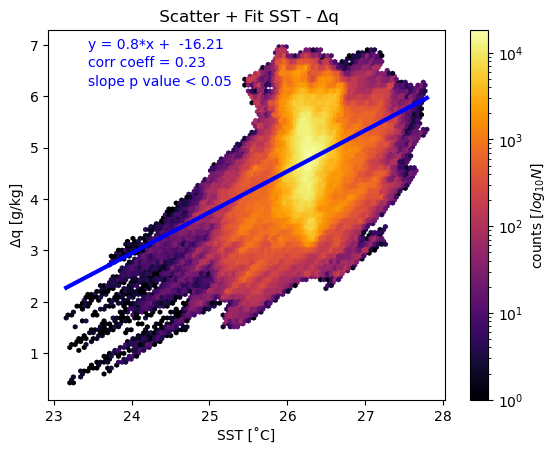

In [65]:
##### FITTING #####

# # corr length
# L = 80
# nskip = int(L/2)
# nt = int(2)
# nbin = 50
dsst = False

if not dsst:
    x = (sst_day-273.15).copy()      
    y = delta_q.copy()
    fit_dq_sst, corcoe_dq, p_value_dq, p_value_cannelli_dq, sigmas_coeffs_dq = slopes_r_p_mix(x, y, nt, nskip)
    ls_therm_contr = fit_dq_sst.slope
    
    title=' Scatter + Fit SST - Δq'
    xlabel='SST [˚C]'
    ylabel='Δq [g/kg]'
    fig = density_hexbin(x,y,fit=fit_dq_sst,corcoe=corcoe_dq,grdsz=100,\
                         title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno', pos=[0.1,0.95])
else:
    x = dsst_day.copy()       
    y = d_delta_q.copy()
    fit_dq_dsst, corcoe_dq, p_value_dq, p_value_cannelli_dq, sigmas_coeffs_dq  = slopes_r_p_mix(x, y, nt, nskip)
    ss_therm_contr = fit_dq_dsst.slope
    
    title='Scatter + Fit dSST - Δq anoms'
    xlabel='SST anoms [˚C]'
    ylabel='Δq anoms [g/kg]'
    fig = density_hexbin(x,y,fit=fit_dq_dsst,corcoe=corcoe_dq,grdsz=100,\
                         title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno',pos=[0.1,0.95])
    

    
if p_value_cannelli_dq < 0.05:
    plt.annotate('slope p value < 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=10, color='b')


    

######  PREVIOUSLY SAVED IN QVAPOR  #######    
path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
filename = path_img + 'scatterFIT_dsst_dDELTAQ_feb.png' if dsst else path_img + 'scatterFIT_sst_DELTAQ_feb.png'
#plt.savefig(filename)
print(filename)
del filename
######  PREVIOUSLY SAVED IN QVAPOR  #######

In [ ]:
###### trying to estimate aerodynamic coefficient

In [66]:
U = np.load('/venus/tesi_ale/data_EU/WIND/daily/FEB/U/U_day_feb.npy')
V = np.load('/venus/tesi_ale/data_EU/WIND/daily/FEB/V/V_day_feb.npy')

ws = np.sqrt(U**2+V**2)

# I KNOW THIS IS WRONG, I SHOULD CORRECT IT FOR THE LOG PROFILE
ws_10 = (ws[:,0,:,:]+ws[:,1,:,:])*0.5 

del U, V, ws

In [70]:
## trying to estimate air density, see if ths changes the estimate of C
T_virt = (T2*units.kelvin)*(1+0.61*q2_day*units('kg/kg'))
Rd = 287.058
rho_air = pres_sfc*100/(Rd*T_virt.magnitude)   # pressure is in hPa

In [71]:
L_v = 2.5008991412E+03  # units = J/kg  ; function in meteo.py is a correction of order 10^4/10^6 = 10^-2

ingredients = L_v*ws_10*(delta_q) # units = J/kg * m/s
ingredients_rho = rho_air*L_v*ws_10*(delta_q) #  # units = W/m2

/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/scatterFIT_C_feb.png


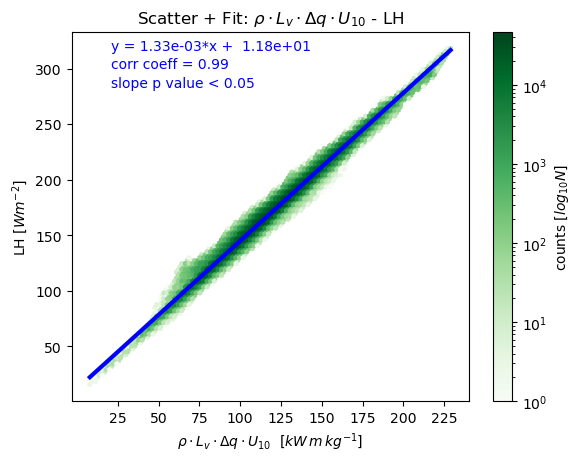

In [75]:
# FIT FOR    C

x = ingredients_rho.values.copy()  
y = LH.copy()
fit_rho, corcoe_rho, p_value_rho, p_value_cannelli_rho, sigmas_coeffs_rho = slopes_r_p_mix(x, y, nt, nskip)
title=r'Scatter + Fit: $\rho \cdot L_v \cdot \Delta q \cdot U_{10}$ - LH'
xlabel=r'$\rho \cdot L_v \cdot \Delta q \cdot U_{10}$  [$kW \, m \, kg^{-1}$]'
ylabel='LH [$Wm^{-2}$]'

plt.xticks([25*(10**3), 50*(10**3), 75*(10**3), 100*(10**3), 125*(10**3), 150*(10**3), 175*(10**3),200*(10**3), 225*(10**3)],\
           ['25', '50', '75', '100', '125', '150','175', '200', '225'])  
 

fig = density_hexbin(x,y,fit=fit_rho,corcoe=corcoe_rho,grdsz=100,\
                     title=title,xlabel=xlabel,ylabel=ylabel, colormap='Greens', pos=[0.1,0.95])


if p_value_cannelli_rho < 0.05:
    plt.annotate('slope p value < 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=10, color='b')
    
path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
filename = path_img + 'scatterFIT_C_feb.png'
#plt.savefig(filename)
print(filename)
del filename

/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/scatterFIT_rho-C_feb.png


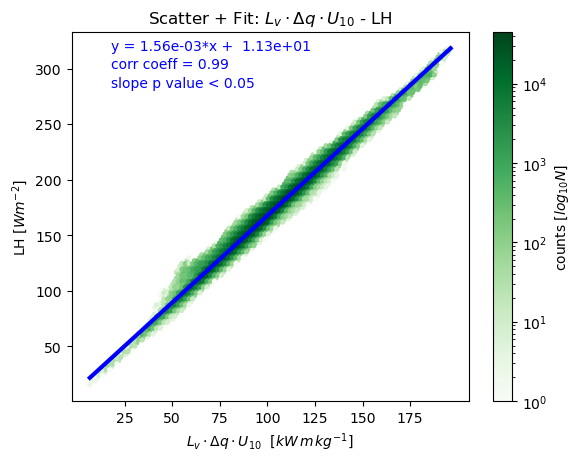

In [76]:
# FIT FOR    rho C

x = ingredients.copy()      # .values if using rho 
y = LH.copy()
fit_lh, corcoe_lh, p_value_lh, p_value_cannelli_lh, sigmas_coeffs_lh = slopes_r_p_mix(x, y, nt, nskip)
title=r'Scatter + Fit: $L_v \cdot \Delta q \cdot U_{10}$ - LH'
xlabel=r'$L_v \cdot \Delta q \cdot U_{10}$  [$kW \, m \, kg^{-1}$]'
ylabel='LH [$Wm^{-2}$]'

plt.xticks([25*(10**3), 50*(10**3), 75*(10**3), 100*(10**3), 125*(10**3), 150*(10**3), 175*(10**3)],\
           ['25', '50', '75', '100', '125', '150','175'])   # 200*(10**3), 225*(10**3)  # , '200', '225'
 

fig = density_hexbin(x,y,fit=fit_lh,corcoe=corcoe_lh,grdsz=100,\
                     title=title,xlabel=xlabel,ylabel=ylabel, colormap='Greens', pos=[0.1,0.95])


if p_value_cannelli_lh < 0.05:
    plt.annotate('slope p value < 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=10, color='b')

    
path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
filename = path_img + 'scatterFIT_rho-C_feb.png'
#plt.savefig(filename)
print(filename)
del filename

In [77]:
rho_C = round(fit_lh.slope, 4);    sigma_rhoC = round(sigmas_coeffs_lh[0], 5)
C = round(fit_rho.slope, 4);       sigma_C = round(sigmas_coeffs_rho[0], 5)

#### RESULT IS VERY MUCH IN LINE WITH VALUE USED BY PABLO!
#### THERE IS ONLY THAT INTERCEPT RUINING THE PARTY

msg = f'C = {C} ± {sigma_C}\nrho_C = {rho_C} ± {sigma_rhoC} \nrelative errors respectively {round(sigma_C/C, 4)} and {sigma_rhoC/rho_C}'
print(msg)

C = 0.0013 ± 1e-05
rho_C = 0.0016 ± 2e-05 
relative errors respectively 0.0077 and 0.0125


In [78]:
# find most frequent thermodyn contr
ws_10_mode = np.mean(ws_10[~np.isnan(ws_10)], axis=None)
rho_mode = np.mean(rho_air.values[~np.isnan(rho_air.values)], axis=None)

In [79]:
print(f'large scale rho_C = {round(rho_C*L_v*ls_therm_contr*(ws_10_mode),3)} W/m2')
print(f'large scale C     = {round((rho_mode)*C*L_v*ls_therm_contr*(ws_10_mode),3)} W/m2')
print('\n')
print(f'small scale rho_C = {round(rho_C*L_v*ss_therm_contr*(ws_10_mode),3)} W/m2')
print(f'small scale C     = {round((rho_mode)*C*L_v*ss_therm_contr*(ws_10_mode),3)} W/m2')

large scale rho_C = 27.717 W/m2
large scale C     = 26.364 W/m2


small scale rho_C = 41.456 W/m2
small scale C     = 39.432 W/m2


/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/violins_full-SS_rho-C_feb.png


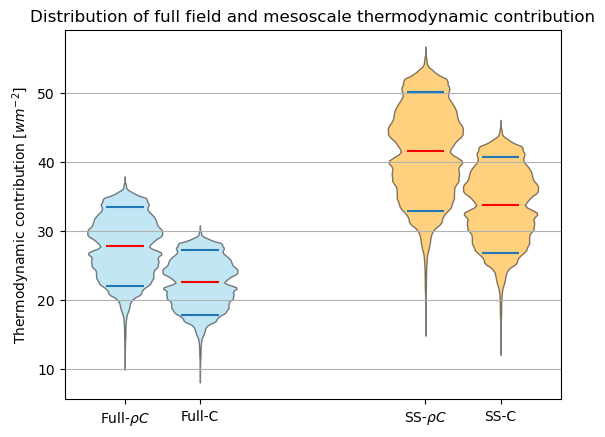

So far, I have been comparing the FULL FIELDS with ANOMALIES

I am now to study the actual differences between SMOOTH FIELDS and ANOMALIES --> SPLIT THE SPECTRUM!!

In [11]:
#### SST SMOOTH
with open('/venus/tesi_ale/data_EU/SST/daily/FEB/dSST_day_feb.npy', 'rb') as f:
    dsst_day = np.load(f)
    f.close()

sst_smooth = sst_day - dsst_day;   sst_smooth -= 273.15

In [11]:
#### T2 SMOOTH
T2_smooth = T2 - dT2;              T2_smooth -= 273.15

In [28]:
#### RH2 SMOOTH
rh2_day = np.load('/venus/tesi_ale/data_EU/RH/daily/FEB/rh2_day.npy')
drh2_day = np.load('/venus/tesi_ale/data_EU/RH/daily/FEB/drh2_day.npy')

rh2_smooth = rh2_day - drh2_day

In [13]:
#### QSAT_SST SMOOTH
qsat_sst = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/qsat_sst_day.npy')
dqsat_sst = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/dqsat_sst_day.npy')

qsat_sst_smooth = qsat_sst - dqsat_sst

In [14]:
#### Q2 SMOOTH
dq2 = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/dq2_day_feb.npy')

q2_smooth = q2_day - dq2

In [15]:
#### DELTA_Q SMOOTH
delta_q = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/deltaQ_day_feb.npy')
d_delta_q = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/DdeltaQ_day_feb.npy')

deltaq_smooth = delta_q - d_delta_q

In [100]:
delta_q[0,220,330]

4.834394454956055

/venus/tesi_ale/img_EU/RH/daily/FEB/scatterFIT_T2-smooth_sst-smooth_feb.png


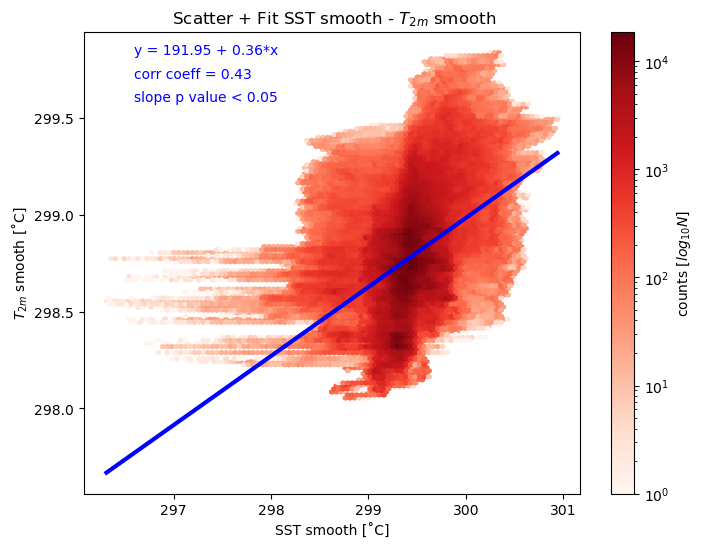

In [62]:
####### CHECK THAT FULL T2 vs SST
####### FOLLOWS T2 vs SST smooth

fig, ax = plt.subplots(1,1, figsize=(8,6))

x =  sst_day
y =  T2_smooth
fit_T2_sst_sm, corcoe_T2_sst_sm, p_value_T2_sst_sm, p_value_cann_T2_sst_sm, sigmas_T2_sst_sm = slopes_r_p_mix(x, y, nt, nskip)
   
density_hexbin_subplots(x, y, fit=fit_T2_sst_sm, corcoe=corcoe_T2_sst_sm, grdsz=100, fig=fig, ax=ax,\
                        title=r' Scatter + Fit SST smooth - $T_{2m}$ smooth', xlabel='SST smooth [˚C]', ylabel=r'$T_{2m}$ smooth [˚C]', colormap='Reds')
    

    
if p_value_cann_T2_sst_sm < 0.05:
    ax.annotate('slope p value < 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    ax.annotate('slope p value > 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=10, color='b')

    
    
path_img = '/venus/tesi_ale/img_EU/RH/daily/FEB/' 
filename = path_img + 'scatterFIT_T2-smooth_sst-smooth_feb.png'
#plt.savefig(filename)
print(filename)
del filename    


0.5141983737969724

/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/scatterFIT_qsat-smooth_sst-smooth_feb.png


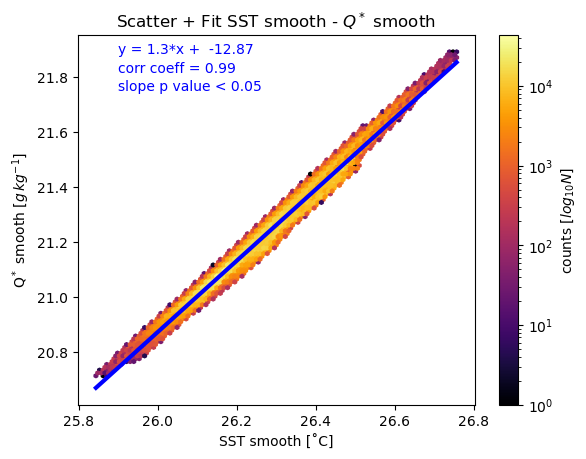

In [97]:
### DELTA_Q vs SST smooth

x = sst_smooth.copy()
y = qsat_sst_smooth.copy()

posx, posy_fit = 0.1, 0.95

fit_qsat_sst_sm, corcoe_qsat_sst_sm, p_value_qsat_sst_sm, pval_cann_qsat_sst_sm, sigmas_qsat_sst_sm  = slopes_r_p_mix(x, y, nt, nskip)
#smooth_therm_contr = fit_qsat_sst_sm.slope
    
title=r'Scatter + Fit SST smooth - $Q^*$ smooth'
xlabel='SST smooth [˚C]'
ylabel=r'$\rm Q^*$ smooth [$g\,kg^{-1}$]'
fig = density_hexbin(x, y, fit=fit_qsat_sst_sm, corcoe=corcoe_qsat_sst_sm, grdsz=100,\
                     title=title, xlabel=xlabel, ylabel=ylabel, colormap='inferno',pos=[posx,posy_fit])
    

    
if pval_cann_qsat_sst_sm < 0.05:
    plt.annotate('slope p value < 0.05', xy=(posx, posy_fit-0.1), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(posx, posy_fit-0.1), \
                         xycoords='axes fraction', fontsize=10, color='b')


       
path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
filename = path_img + 'scatterFIT_qsat-smooth_sst-smooth_feb.png'
#plt.savefig(filename)
print(filename)
del filename

/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/scatterFIT_q2-smooth_sst-smooth_feb.png


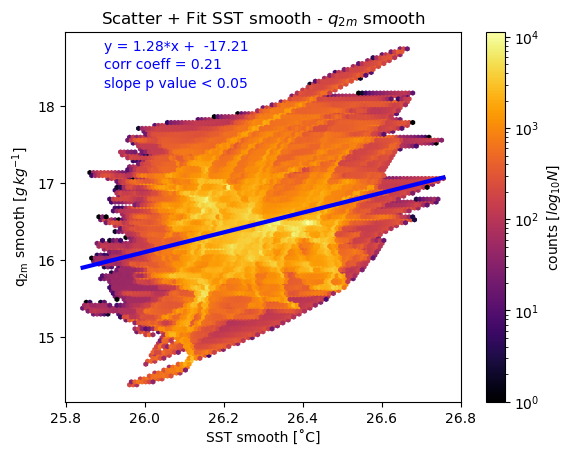

In [111]:
### DELTA_Q vs SST smooth

x = sst_smooth.copy()
y = q2_smooth.copy()*1000

posx, posy_fit = 0.1, 0.95

fit_q2_sst_sm, corcoe_q2_sst_sm, p_value_q2_sst_sm, pval_cann_q2_sst_sm, sigmas_q2_sst_sm  = slopes_r_p_mix(x, y, nt, nskip)
#smooth_therm_contr = fit_q2_sst_sm.slope
    
title=r'Scatter + Fit SST smooth - $q_{2m}$ smooth'
xlabel='SST smooth [˚C]'
ylabel=r'$\rm q_{2m}$ smooth [$g\,kg^{-1}$]'
fig = density_hexbin(x, y, fit=fit_q2_sst_sm, corcoe=corcoe_q2_sst_sm, grdsz=100,\
                     title=title, xlabel=xlabel, ylabel=ylabel, colormap='inferno',pos=[posx,posy_fit])
    

    
if pval_cann_q2_sst_sm < 0.05:
    plt.annotate('slope p value < 0.05', xy=(posx, posy_fit-0.1), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(posx, posy_fit-0.1), \
                         xycoords='axes fraction', fontsize=10, color='b')


       
path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
filename = path_img + 'scatterFIT_q2-smooth_sst-smooth_feb.png'
plt.savefig(filename)
print(filename)
del filename

/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/pointRegr_q2-smooth_sst-smooth_feb.png


"hatch_mask = np.zeros_like(slope_q2_sst)\nhatch_mask[p_val_q2_sst > 0.05] = 1\ncont1 = ax1.contourf(lon_M, lat_M, hatch_mask, levels=[0.9, 1.1], hatches=['...', None],  colors='none', alpha=0.1)"

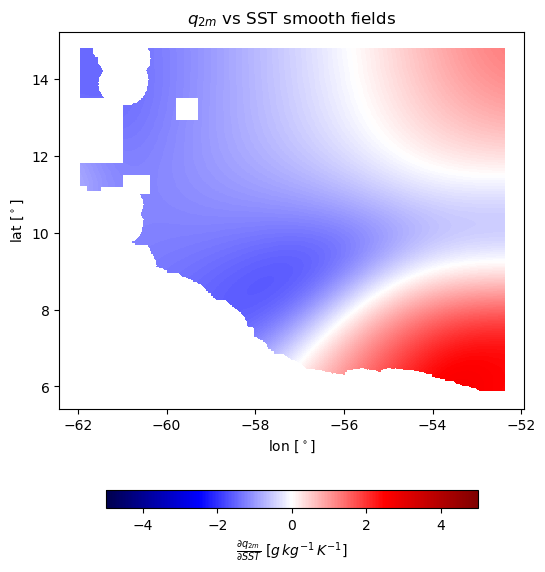

In [23]:
##### POINTWISE REGRESSIONS
import matplotlib as mpl

fig, ax1 = plt.subplots(1,1, figsize=(6,7))


x = sst_smooth.copy()         
y = q2_smooth*1000.                   

n_q2_sst, slope_q2_sst, intercept_q2_sst, cor_q2_sst, p_val_q2_sst, r_square_q2_sst, rmse_q2_sst =\
regression.MY_point_regr(x,y) 

p1 = ax1.pcolormesh(lon_M, lat_M, slope_q2_sst, vmin=-5, vmax=5, cmap='seismic')

cbar1 = plt.colorbar(p1,ax=ax1, location='bottom', shrink=0.8)#, extend='both')  
cbar1.set_label(r'$\frac{\partial q_{2m}}{\partial SST}$ [$g\,kg^{-1}\,K^{-1}$]')
ax1.set_title(r'$q_{2m}$ vs SST smooth fields'); ax1.set_xlabel('lon [$^\circ$]'); ax1.set_ylabel('lat [$^\circ$]')

path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
filename = path_img + 'pointRegr_q2-smooth_sst-smooth_feb.png'
# plt.savefig(filename)
print(filename)
del filename


# Hatching for p-values less than 0.05
'''lat_hatch = lat_M[p_val_LH_sst > 0.05]
lon_hatch = lon_M[p_val_LH_sst > 0.05]
ax1.scatter(lon_hatch, lat_hatch, s=0.01, color='k')'''
'''hatch_mask = np.zeros_like(slope_q2_sst)
hatch_mask[p_val_q2_sst > 0.05] = 1
cont1 = ax1.contourf(lon_M, lat_M, hatch_mask, levels=[0.9, 1.1], hatches=['...', None],  colors='none', alpha=0.1)'''

/venus/tesi_ale/img_EU/RH/daily/FEB/scatterFIT_rh-smooth_sst-smooth_feb.png


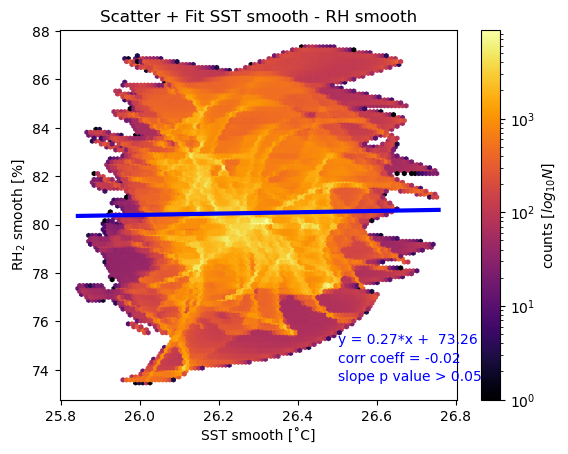

In [54]:
##### RH vs SST smooth
### you can find small scale computations in QVAPOR_day.ipynb

x = sst_smooth.copy()
y = rh2_smooth.copy()
fit_rh_sst_sm, corcoe_rh_sst_sm, p_value_rh_sst_sm, pval_cann_rh_sst_sm, sigmas_rh_sst_sm  = slopes_r_p_mix(x, y, nt, nskip)
#smooth_therm_contr = fit_rh_sst_sm.slope
    
title='Scatter + Fit SST smooth - RH smooth'
xlabel='SST smooth [˚C]'
ylabel=r'$\rm RH_{2}$ smooth [%]'
fig = density_hexbin(x, y, fit=fit_rh_sst_sm, corcoe=corcoe_rh_sst_sm, grdsz=100,\
                     title=title, xlabel=xlabel, ylabel=ylabel, colormap='inferno',pos=[0.7,0.15])
    

    
if pval_cann_rh_sst_sm < 0.05:
    plt.annotate('slope p value < 0.05', xy=(0.7, 0.05), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(0.7, 0.05), \
                         xycoords='axes fraction', fontsize=10, color='b')


       
path_img = '/venus/tesi_ale/img_EU/RH/daily/FEB/' 
filename = path_img + 'scatterFIT_rh-smooth_sst-smooth_feb.png'
#plt.savefig(filename)
print(filename)
del filename


/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/scatterFIT_deltaq-smooth_sst-full_feb.png


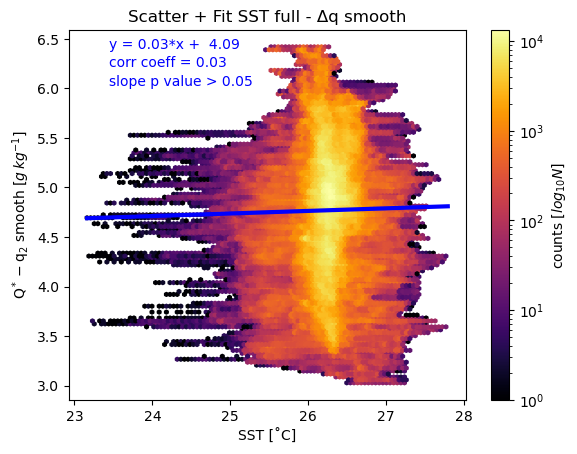

In [86]:
### DELTA_Q vs SST smooth

x = sst_day.copy()-273.15
y = deltaq_smooth.copy()

posx, posy_fit = 0.1, 0.95

fit_deltaq_sst_sm, corcoe_deltaq_sst_sm, p_value_deltaq_sst_sm, pval_cann_deltaq_sst_sm, sigmas_deltaq_sst_sm  = slopes_r_p_mix(x, y, nt, nskip)
smooth_therm_contr = fit_deltaq_sst_sm.slope
    
title='Scatter + Fit SST full - Δq smooth'
xlabel='SST [˚C]'
ylabel=r'$\rm Q^* - q_{2}$ smooth [$g\,kg^{-1}$]'
fig = density_hexbin(x, y, fit=fit_deltaq_sst_sm, corcoe=corcoe_deltaq_sst_sm, grdsz=100,\
                     title=title, xlabel=xlabel, ylabel=ylabel, colormap='inferno',pos=[posx,posy_fit])
    

    
if pval_cann_deltaq_sst_sm < 0.05:
    plt.annotate('slope p value < 0.05', xy=(posx, posy_fit-0.1), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(posx, posy_fit-0.1), \
                         xycoords='axes fraction', fontsize=10, color='b')


       
path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
filename = path_img + 'scatterFIT_deltaq-smooth_sst-full_feb.png'
#plt.savefig(filename)
print(filename)
del filename

In [80]:
data5 = rho_C*L_v*ws_10*smooth_therm_contr;   data5 = data5[~np.isnan(data5)]
data6 = C*L_v*ws_10*smooth_therm_contr;       data6 = data6[~np.isnan(data6)]

/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/violins_full-SS-LS_rho-C_feb.png


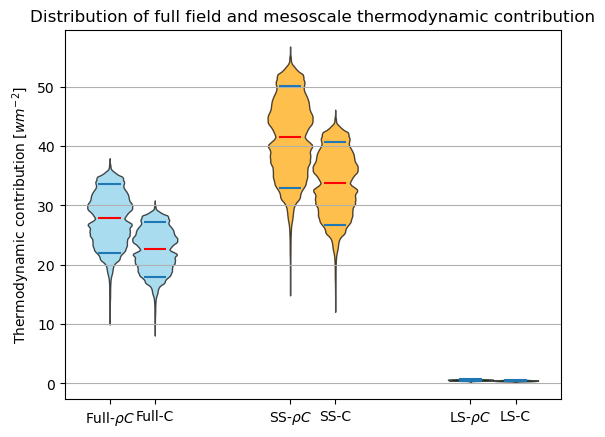

In [87]:
data1 = rho_C*L_v*ws_10*ls_therm_contr; data1 = data1[~np.isnan(data1)]
data2 = rho_C*L_v*ws_10*ss_therm_contr; data2 = data2[~np.isnan(data2)]
data3 = C*L_v*ws_10*ls_therm_contr; data3 = data3[~np.isnan(data3)]
data4 = C*L_v*ws_10*ss_therm_contr; data4 = data4[~np.isnan(data4)]



fig, axs = plt.subplots(1,1)
quants = [[0.1, 0.9] , [0.1, 0.9], [0.1, 0.9], [0.1, 0.9], [0.1, 0.9], [0.1, 0.9]]
pos = [ 1,1.5, 3,3.5, 5,5.5]
colorz = ['skyblue', 'skyblue', 'orange', 'orange', 'green', 'green']


plt.title('Distribution of full field and mesoscale thermodynamic contribution')


violin_parts1 = axs.violinplot([data1, data3, data2, data4, data5, data6],\
                               positions=pos, showmeans=False,\
                               showmedians=True, showextrema=False, quantiles=quants)
violin_parts1['cmedians'].set_color('red')



# set color of violins inside
for pc, color in zip(violin_parts1['bodies'], colorz):
    pc.set_facecolor(color)
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)


# set labels I need
axs.yaxis.grid(True)
axs.set_ylabel(r'Thermodynamic contribution [$wm^{-2}$]')

axs.set_xticks(pos)
axs.set_xticklabels([r'Full-$\rho C$','Full-C', r'SS-$\rho C$', 'SS-C', r'LS-$\rho C$', 'LS-C'])
axs.set_xlabel('')



# save img
path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
filename = path_img + 'violins_full-SS-LS_rho-C_feb.png'
#plt.savefig(filename)
print(filename)
del filename